##### ASakai
https://github.com/AtsushiSakai/PythonRobotics/blob/master/Localization/extended_kalman_filter/extended_kalman_filter_localization.ipynb

##### RLabbe
https://github.com/rlabbe/Kalman-and-Bayesian-Filters-in-Python/blob/master/06-Multivariate-Kalman-Filters.ipynb

In [1]:
import os
import json
from pprint import pprint
import numpy as np

In [2]:
file_path = os.path.join(os.getcwd(), 'data')
drive_file = 'drive_data_200703.json'
message_file = 'drive_messages_200703.json'

def load_json_fstr(fstr):
    with open(os.path.join(file_path, fstr), 'r') as f:
        res = json.load(f)
    return res

drive_data = load_json_fstr(drive_file)
message_data = load_json_fstr(message_file)

In [3]:
pprint(drive_data)
pprint(message_data)

[{'t': 1593654375.300795,
  'theta_control': 3.130684345764829,
  'theta_sensor': 3.1306357252551913,
  'x_control': 0.0,
  'x_sensor': -0.007493959334527899,
  'y_control': 0.0,
  'y_sensor': 8.193185955324729e-05},
 {'t': 1593654375.388365,
  'theta_control': 3.1275110198521117,
  'theta_sensor': 3.1279610518097414,
  'x_control': -27.91669399388545,
  'x_sensor': -1.7167211809614902,
  'y_control': 2.85226826405742,
  'y_sensor': 0.021096683161982464},
 {'t': 1593654375.462107,
  'theta_control': 3.1275110198521117,
  'theta_sensor': 3.1302133730295014,
  'x_control': -27.91669399388545,
  'x_sensor': -3.766347360484601,
  'y_control': 2.85226826405742,
  'y_sensor': 0.04672949898974568},
 {'t': 1593654375.535083,
  'theta_control': 3.130684345764829,
  'theta_sensor': 3.133795574052757,
  'x_control': -101.97940954699784,
  'x_sensor': -6.063640670835743,
  'y_control': -2.849003432084163,
  'y_sensor': 0.0687570358987552},
 {'t': 1593654375.607858,
  'theta_control': 3.13385767167

  'theta_control': 5.133052996689229,
  'theta_sensor': 5.539170947836304,
  'x_control': -513.9237898827286,
  'x_sensor': 48.70864517458894,
  'y_control': -1046.9041104569733,
  'y_sensor': -250.20846569896986},
 {'t': 1593654382.623102,
  'theta_control': 5.133052996689229,
  'theta_sensor': 5.539012646473148,
  'x_control': -513.9237898827286,
  'x_sensor': 51.67759600086999,
  'y_control': -1046.9041104569733,
  'y_sensor': -252.94175350048607}]
[['drive', 10, 1593654376.010054],
 ['turn', 45, 1593654376.423286],
 ['drive', 10, 1593654377.13599],
 ['turn', 45, 1593654377.542922],
 ['drive', 10, 1593654378.253548],
 ['turn', 45, 1593654378.660481],
 ['drive', 10, 1593654379.371228],
 ['turn', 45, 1593654379.779187],
 ['drive', 10, 1593654380.490991]]


Set Initial Conditions

In [19]:
prior_dat = {
    't': drive_data[0].get('t'),
    'x_control': 0,
    'y_control': 0, 
    'x_sensor': 0,
    'y_sensor': 0,
    'theta_control': drive_data[0].get('theta_control'),
    'theta_sensor': drive_data[0].get('theta_control')
}

x_true = np.array([0, 0, drive_data[0].get('theta_control')])

F = np.identity(3)
P = np.identity(3)
H = np.identity(3)
J_obs = np.identity(3)
Q = np.zeros([3,3])
R = np.zeros([3,3])

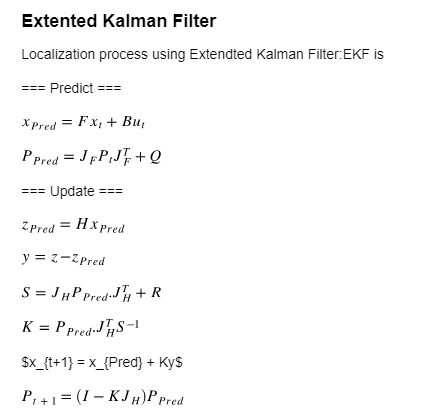

In [20]:
for i, curr_dat in enumerate(drive_data, 1):
    dt = curr_dat['t'] - prior_dat['t']
    u_t_control = np.array(
        [curr_dat['x_control'] - prior_dat['x_control'],
         curr_dat['y_control'] - prior_dat['y_control'],
         0])
    
    u_t_sensor = np.array(
        [curr_dat['x_sensor'] - prior_dat['x_sensor'],
         curr_dat['y_sensor'] - prior_dat['y_sensor'],
         0])
    
    J_control = np.array([
        [1, 0, dt*0],
        [0, 1, dt*0],
        [0, 0, 1]
    ])
    J_sensor = np.array([
        [1, 0, dt*0],
        [0, 1, dt*0],
        [0, 0, 1]
    ])
    
    # === Predict ===
    x_pred_control = x_true + u_t_control
    x_pred_sensor = x_true + u_t_sensor
    P_pred = J_obs.dot(P).dot(J_obs.T) + Q
    # === Update ===
    z_pred_control = H.dot(x_pred_control)
    z_pred_sensor = H.dot(x_pred_sensor)
    y = z_pred_sensor - z_pred_control
    S = J_sensor.dot(P_pred).dot(J_sensor.T) + R
    K = P_pred.dot(J_sensor.T).dot(np.linalg.inv(S))
    x_true = x_pred_control + K.dot(y)
    
    # Review
    print(
        f"x_true: {x_true}"
        # f"\nP {P}"
        f"\ny: {y}"
        f"\n"
    )
    # Setup for Next Iteration
    prior_dat = curr_dat
        

x_true: [-7.49395933e-03  8.19318596e-05  3.13068435e+00]
y: [-7.49395933e-03  8.19318596e-05  0.00000000e+00]

x_true: [-1.71672118  0.02109668  3.13068435]
y: [26.20746677 -2.83125351  0.        ]

x_true: [-3.76634736  0.0467295   3.13068435]
y: [-2.04962618  0.02563282  0.        ]

x_true: [-6.06364067  0.06875704  3.13068435]
y: [71.76542224  5.72329923  0.        ]

x_true: [-8.04934757  0.08266362  3.13068435]
y: [75.34939937  6.21400844  0.        ]

x_true: [-10.13250526   0.09707452   3.13068435]
y: [71.83756035 -7.30117367  0.        ]

x_true: [-12.17273474   0.10933038   3.13068435]
y: [-2.04022947  0.01225586  0.        ]

x_true: [-14.32395092   0.12336149   3.13068435]
y: [-2.15121618  0.01403111  0.        ]

x_true: [-16.49024493   0.13815496   3.13068435]
y: [-2.16629401  0.01479347  0.        ]

x_true: [-17.79677389   0.14615173   3.13068435]
y: [-1.30652895  0.00799677  0.        ]

x_true: [-18.75463087   0.15437574   3.13068435]
y: [-0.95785698  0.00822401  0. 

In [6]:
print(drive_data[-1])

{'theta_control': 5.133052996689229, 'y_sensor': -252.94175350048607, 'y_control': -1046.9041104569733, 'x_sensor': 51.67759600086999, 'theta_sensor': 5.539012646473148, 't': 1593654382.623102, 'x_control': -513.9237898827286}


In [ ]:
F.dot(x_true)